# Deep Learning - Introduction à Pytorch


## TP2 : Fonctions Dérivables

Sylvain Lamprier (sylvain.lamprier@univ-angers.fr)

Supports adaptés de Nicolas Baskiotis (nicolas.baskiotis@sorbonne-univeriste.fr) et Benjamin Piwowarski (benjamin.piwowarski@sorbonne-universite.fr) -- MLIA/ISIR, Sorbonne Université

In [1]:
import torch
print("La version de torch est : ",torch.__version__)
print("Le calcul GPU est disponible ? ", torch.cuda.is_available())

import numpy as np
import sklearn
print("sklearn ",sklearn.__version__)
print("numpy ",np.__version__)

La version de torch est :  2.5.1+cu124
Le calcul GPU est disponible ?  False
sklearn  1.5.2
numpy  2.1.3


In [2]:
import torch
from torch.autograd import Function
from torch.autograd import gradcheck


class Context:
    """Un objet contexte très simplifié pour simuler PyTorch

    Un contexte différent doit être utilisé à chaque forward
    """
    def __init__(self):
        self._saved_tensors = ()
    def save_for_backward(self, *args):
        self._saved_tensors = args
    @property
    def saved_tensors(self):
        return self._saved_tensors


class MSE(Function):
    """Début d'implementation de la fonction MSE"""
    # ctx est un objet contexte calculé par les fonctions précédentes
    # yhat est la prédiction du modèle ( c'est une fonction loss)
    # moindre carré entre yhat et y
    # ctx.savebackwards permet de sauvegarder les valeurs nécessaires pour le backward
    @staticmethod
    def forward(ctx, yhat, y):
        # Sauvegarde des valeurs nécessaires pour le backward
        ctx.save_for_backward(yhat, y)
        
        # Calcul de la perte MSE : Mean((yhat - y)^2)
        #loss = torch.mean((yhat - y) ** 2)
        loss = ((yhat - y) ** 2).mean(0)
        return loss

    # recuperer les tensors sauvegardés dans le contexte pendant le forward
    # pour calculer les gradients
    # retourne le gradient par rapport au premier element passer dans le forward (yhat) 
    # et le gradient par rapport au deuxieme element passer dans le forward (y)
    # recuper tensor et calculer gradiant qui utilse grad_output
    # transformer grad_output en tensor et retourner le tuple de gradient de yhat et y
    @staticmethod
    def backward(ctx, grad_output):
        # Récupérer les valeurs sauvegardées
        yhat, y = ctx.saved_tensors
    
        N = yhat.size(0) # Nombre d'exemples dans le batch
        grad_yhat = 2/N * (yhat - y) # Gradient par rapport à yhat
        grad_y = -2/N * (yhat - y) # Gradient par rapport à y
    
        # Retourner les gradients ajustés avec grad_output
        return grad_output * grad_yhat, grad_output * grad_y

        

# [[STUDENT]] Implémenter la fonction Linear(X, W, b)sur le même modèle que MSE
# avec X le batch d'exemple, W les poids, b le biais
# retourne XW + b
class Linear(Function):
    @staticmethod
    def forward(ctx, x, w, b):
        # Sauvegarde des valeurs nécessaires pour le backward
        ctx.save_for_backward(x, w, b)
        
        # Calcul de la sortie
        output = torch.mm(x, w) + b
        return output

    @staticmethod
    def backward(ctx, grad_output):
        # Récupérer les valeurs sauvegardées
        x, w, b = ctx.saved_tensors
        
        # Calcul des gradients locaux
        grad_x = torch.mm(grad_output, w.t())
        grad_w = torch.mm(x.t(), grad_output)
        grad_b = grad_output.sum(0)
        
        return grad_x, grad_w, grad_b

## Utile pour gradcheck
mse = MSE.apply
linear = Linear.apply

In [3]:
# Test du gradient de MSE
yhat = torch.randn(10,5, requires_grad=True, dtype=torch.float64)
y = torch.randn(10,5, requires_grad=True, dtype=torch.float64)
torch.autograd.gradcheck(mse, (yhat, y))

True

In [4]:
# Test du gradient de Linear (sur le même modèle que MSE)
x = torch.randn(13, 5,requires_grad=True,dtype=torch.float64)
w = torch.randn(5, 7,requires_grad=True,dtype=torch.float64)
b = torch.randn(7,requires_grad=True,dtype=torch.float64)
torch.autograd.gradcheck(linear,(x,w,b))

True

In [5]:
# modulaire ( ajouter fonction tanh avec son forward et backward)
class Tanh(Function):
    @staticmethod
    def forward(ctx, x):
        # Calculer tanh et sauvegarder le contexte pour le backward
        ctx.save_for_backward(x)
        return torch.tanh(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Récupérer x depuis le contexte
        (x,) = ctx.saved_tensors
        # Calculer le gradient local : 1 - tanh^2(x)
        grad_x = 1 - torch.tanh(x)**2
        # Appliquer la règle de la chaîne
        return grad_output * grad_x
    
tanh = Tanh.apply

In [6]:
print("Testing Tanh:")
x = torch.randn(13, 5,requires_grad=True,dtype=torch.float64)
torch.autograd.gradcheck(tanh,(x,))

Testing Tanh:


True

In [7]:
class ReLU(Function):
    @staticmethod
    def forward(ctx, x):
        # Calculer ReLU et sauvegarder le contexte pour le backward
        ctx.save_for_backward(x)
        return torch.relu(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Récupérer x depuis le contexte
        (x,) = ctx.saved_tensors
        # Calculer le gradient local : 1 si x > 0, sinon 0
        grad_x = (x > 0).to(x.dtype)  # Convertir en même type que x
        # Appliquer la règle de la chaîne
        return grad_output * grad_x

In [8]:
# Tester ReLU avec gradcheck
print("Testing ReLU:")
relu = ReLU.apply
torch.autograd.gradcheck(relu, (x,))

Testing ReLU:


True

## Descente de Gradient

Compléter ci-dessous le code pour réaliser la même regression linéaire qu'au TP précédent, mais en utilisant les objets Function déclarés ci-dessus.

Nombre d'exemples :  20640 Dimension :  8
Itérations 0: loss 5.356249809265137
Itérations 10000: loss 3.7394561767578125
Itérations 20000: loss 2.7165513038635254
Itérations 30000: loss 2.050978422164917
Itérations 40000: loss 1.6084606647491455
Itérations 50000: loss 1.30939519405365
Itérations 60000: loss 1.104760766029358
Itérations 70000: loss 0.963340699672699
Test loss: 1.3584457635879517


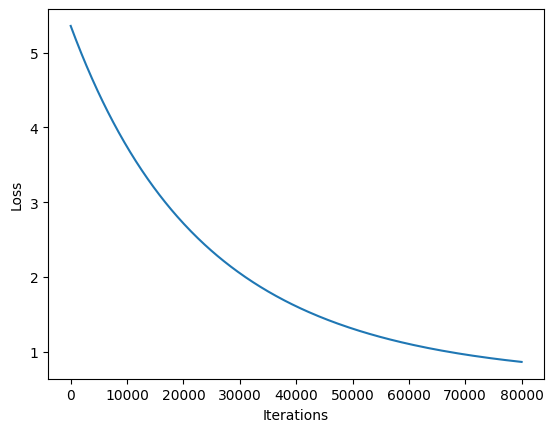

In [9]:
import torch
from torch.autograd import Function
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

housing = fetch_california_housing()  ## chargement des données
x = torch.tensor(housing['data'], dtype=torch.float)
y = torch.tensor(housing['target'], dtype=torch.float).view(-1, 1)
x = (x - x.mean(dim=0)) / x.std(dim=0)

print("Nombre d'exemples : ", x.size(0), "Dimension : ", x.size(1))

x_train = x[:int(0.8 * len(x))]
y_train = y[:int(0.8 * len(y))]
x_test = x[int(0.8 * len(x)):]
y_test = y[int(0.8 * len(y)):]

# Initialisation aléatoire de w et b with small values
w = torch.randn(x.size(1), 1) * 0.01
b = torch.zeros(1, 1)

EPOCHS = 80000
EPS = 1e-5

cost_history = []
cost_final = []

for n_iter in range(EPOCHS):
    ctx_linear = Context()
    ctx_mse = Context()
    yhat = Linear.forward(ctx_linear, x_train, w, b)
    loss = MSE.forward(ctx_mse, yhat, y_train)
    cost_history.append([n_iter, loss.item()])
    if n_iter % 10000 == 0:
        print(f"Itérations {n_iter}: loss {loss.item()}")
    grad_output = torch.tensor(1.0)
    grad_yhat, _ = MSE.backward(ctx_mse, grad_output)
    _, grad_w, grad_b = Linear.backward(ctx_linear, grad_yhat)
    w = w - EPS * grad_w
    b = b - EPS * grad_b
    
# test du modèle 
yhat = Linear.forward(Context(), x_test, w, b)
loss = MSE.forward(Context(), yhat, y_test)
print(f"Test loss: {loss.item()}")
cost_final.append(["lineaire", loss.item()])

cost_history = np.array(cost_history)
plt.plot(cost_history[:, 0], cost_history[:, 1])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

### Regression Non Linéaire

Ajouter une classe Function Tanh sur le modèle des classe déclarées ci-dessus et appliquer une descente de gradient sur le problème précédent qui utilise un réseau de neurones à une couche cachée de 10 neurones. 


In [10]:
# modulaire ( ajouter fonction tanh avec son forward et backward)
class Tanh(Function):
    @staticmethod
    def forward(ctx, x):
        # Calculer tanh et sauvegarder le contexte pour le backward
        ctx.save_for_backward(x)
        return torch.tanh(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Récupérer x depuis le contexte
        (x,) = ctx.saved_tensors
        # Calculer le gradient local : 1 - tanh^2(x)
        grad_x = 1 - torch.tanh(x) ** 2
        # Appliquer la règle de la chaîne
        return grad_output * grad_x


tanh = Tanh.apply

In [11]:
# Test du gradient de Tanh (sur le même modèle que MSE)

x = torch.randn(13, 5,requires_grad=True,dtype=torch.float64)
torch.autograd.gradcheck(tanh,x)

True

Nombre d'exemples :  20640 Dimension :  8
Itérations 0: loss 5.372561454772949
Itérations 10000: loss 1.309428334236145
Itérations 20000: loss 0.9015849232673645
Itérations 30000: loss 0.6454287171363831
Itérations 40000: loss 0.5975487232208252
Itérations 50000: loss 0.5696563720703125
Itérations 60000: loss 0.5467096567153931
Itérations 70000: loss 0.5285033583641052
Test loss: 0.4776679277420044


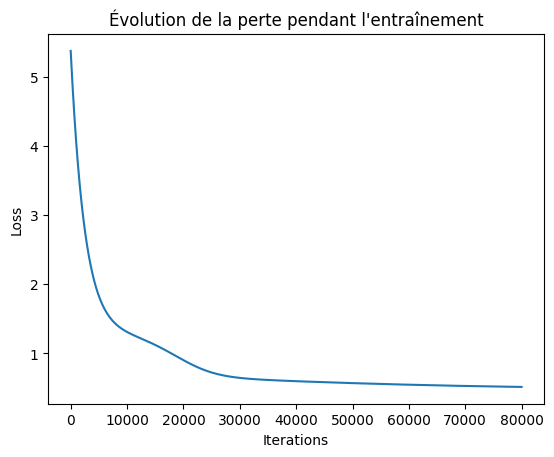

In [12]:
# Chargement des données California_Housing et transformation en tenseurs.
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()  # Chargement des données
x = torch.tensor(housing['data'], dtype=torch.float)
y = torch.tensor(housing['target'], dtype=torch.float).view(-1, 1)

# Normalisation des données
x = (x - x.mean(dim=0)) / x.std(dim=0)

print("Nombre d'exemples : ", x.size(0), "Dimension : ", x.size(1))

# Division des données en ensemble d'entraînement et de test
x_train = x[:int(0.8 * len(x))]
y_train = y[:int(0.8 * len(y))]
x_test = x[int(0.8 * len(x)):]
y_test = y[int(0.8 * len(y)):]

# Initialisation aléatoire des poids et biais avec de petites valeurs
input_dim = x.size(1)  # 8
hidden_dim = 10
output_dim = 1

# Poids et biais pour la couche cachée
w1 = torch.randn(input_dim, hidden_dim) * 0.01
b1 = torch.zeros(1, hidden_dim)

# Poids et biais pour la couche de sortie
w2 = torch.randn(hidden_dim, output_dim) * 0.01
b2 = torch.zeros(1, output_dim)

EPOCHS = 80000
EPS = 1e-4 

cost_history = []

for n_iter in range(EPOCHS):
    # Création des contextes
    ctx_linear1 = Context()
    ctx_tanh = Context()
    ctx_linear2 = Context()
    ctx_mse = Context()

    # Forward pass
    h_pre = Linear.forward(ctx_linear1, x_train, w1, b1)    # Couche cachée linéaire
    h = Tanh.forward(ctx_tanh, h_pre)                       # Activation tanh
    yhat = Linear.forward(ctx_linear2, h, w2, b2)           # Couche de sortie linéaire
    loss = MSE.forward(ctx_mse, yhat, y_train)              # Calcul de la perte MSE

    cost_history.append([n_iter, loss.item()])
    if n_iter % 10000 == 0:
        print(f"Itérations {n_iter}: loss {loss.item()}")

    # Backward pass
    grad_output = torch.tensor(1.0)
    grad_yhat, _ = MSE.backward(ctx_mse, grad_output)                    # Gradient par rapport à yhat
    grad_h, grad_w2, grad_b2 = Linear.backward(ctx_linear2, grad_yhat)   # Gradients couche de sortie
    grad_h_pre = Tanh.backward(ctx_tanh, grad_h)                         # Gradient à travers tanh
    _, grad_w1, grad_b1 = Linear.backward(ctx_linear1, grad_h_pre)       # Gradients couche cachée

    # Mise à jour des poids et biais
    w1 -= EPS * grad_w1
    b1 -= EPS * grad_b1
    w2 -= EPS * grad_w2
    b2 -= EPS * grad_b2

# Test du modèle
ctx_linear1_test = Context()
ctx_tanh_test = Context()
ctx_linear2_test = Context()

h_pre_test = Linear.forward(ctx_linear1_test, x_test, w1, b1)
h_test = Tanh.forward(ctx_tanh_test, h_pre_test)
yhat_test = Linear.forward(ctx_linear2_test, h_test, w2, b2)
loss_test = MSE.forward(Context(), yhat_test, y_test)
print(f"Test loss: {loss_test.item()}")
cost_final.append(["tanh", loss_test.item()])

# Affichage de l'évolution de la perte
cost_history = np.array(cost_history)
plt.plot(cost_history[:, 0], cost_history[:, 1])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Évolution de la perte pendant l'entraînement")
plt.show()

Nombre d'exemples :  20640 Dimension :  8
Itérations 0: loss 5.372941017150879
Itérations 10000: loss 1.3515347242355347
Itérations 20000: loss 1.1534090042114258
Itérations 30000: loss 0.8133518099784851
Itérations 40000: loss 0.6777157783508301
Itérations 50000: loss 0.6390395164489746
Itérations 60000: loss 0.6133211255073547
Itérations 70000: loss 0.5898319482803345
Test loss: 0.567523717880249


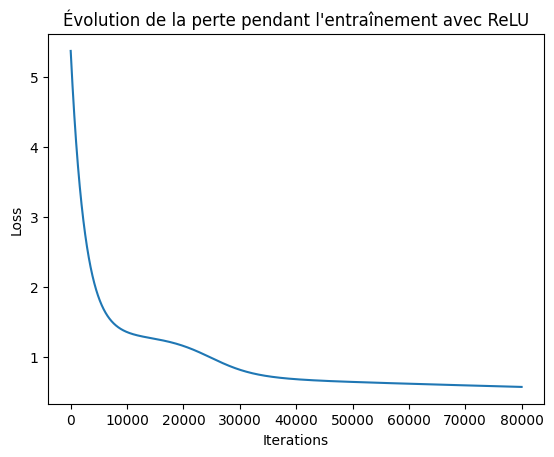

In [13]:
# La meme chose avec relu
# Chargement des données California_Housing et transformation en tenseurs.
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()  # Chargement des données
x = torch.tensor(housing['data'], dtype=torch.float)
y = torch.tensor(housing['target'], dtype=torch.float).view(-1, 1)

# Normalisation des données
x = (x - x.mean(dim=0)) / x.std(dim=0)

print("Nombre d'exemples : ", x.size(0), "Dimension : ", x.size(1))

# Division des données en ensemble d'entraînement et de test
x_train = x[:int(0.8 * len(x))]
y_train = y[:int(0.8 * len(y))]
x_test = x[int(0.8 * len(x)):]
y_test = y[int(0.8 * len(y)):]

# Initialisation aléatoire des poids et biais avec de petites valeurs
input_dim = x.size(1)  # 8
hidden_dim = 10
output_dim = 1

# Poids et biais pour la couche cachée
w1 = torch.randn(input_dim, hidden_dim) * 0.01
b1 = torch.zeros(1, hidden_dim)

# Poids et biais pour la couche de sortie
w2 = torch.randn(hidden_dim, output_dim) * 0.01
b2 = torch.zeros(1, output_dim)

EPOCHS = 80000
EPS = 1e-4 

cost_history = []

for n_iter in range(EPOCHS):
    # Création des contextes
    ctx_linear1 = Context()
    ctx_relu = Context()
    ctx_linear2 = Context()
    ctx_mse = Context()

    # Forward pass
    h_pre = Linear.forward(ctx_linear1, x_train, w1, b1)    # Couche cachée linéaire
    h = ReLU.forward(ctx_relu, h_pre)                       # Activation ReLU
    yhat = Linear.forward(ctx_linear2, h, w2, b2)           # Couche de sortie linéaire
    loss = MSE.forward(ctx_mse, yhat, y_train)              # Calcul de la perte MSE

    cost_history.append([n_iter, loss.item()])
    if n_iter % 10000 == 0:
        print(f"Itérations {n_iter}: loss {loss.item()}")

    # Backward pass
    grad_output = torch.tensor(1.0)
    grad_yhat, _ = MSE.backward(ctx_mse, grad_output)                    # Gradient par rapport à yhat
    grad_h, grad_w2, grad_b2 = Linear.backward(ctx_linear2, grad_yhat)   # Gradients couche de sortie
    grad_h_pre = ReLU.backward(ctx_relu, grad_h)                         # Gradient à travers ReLU
    _, grad_w1, grad_b1 = Linear.backward(ctx_linear1, grad_h_pre)       # Gradients couche cachée

    # Mise à jour des poids et biais
    w1 -= EPS * grad_w1
    b1 -= EPS * grad_b1
    w2 -= EPS * grad_w2
    b2 -= EPS * grad_b2

# Test du modèle
ctx_linear1_test = Context()
ctx_relu_test = Context()
ctx_linear2_test = Context()

h_pre_test = Linear.forward(ctx_linear1_test, x_test, w1, b1)
h_test = ReLU.forward(ctx_relu_test, h_pre_test)
yhat_test = Linear.forward(ctx_linear2_test, h_test, w2, b2)
loss_test = MSE.forward(Context(), yhat_test, y_test)
print(f"Test loss: {loss_test.item()}")
cost_final.append(["relu", loss_test.item()])

# Affichage de l'évolution de la perte
cost_history = np.array(cost_history)
plt.plot(cost_history[:, 0], cost_history[:, 1])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Évolution de la perte pendant l'entraînement avec ReLU")
plt.show()

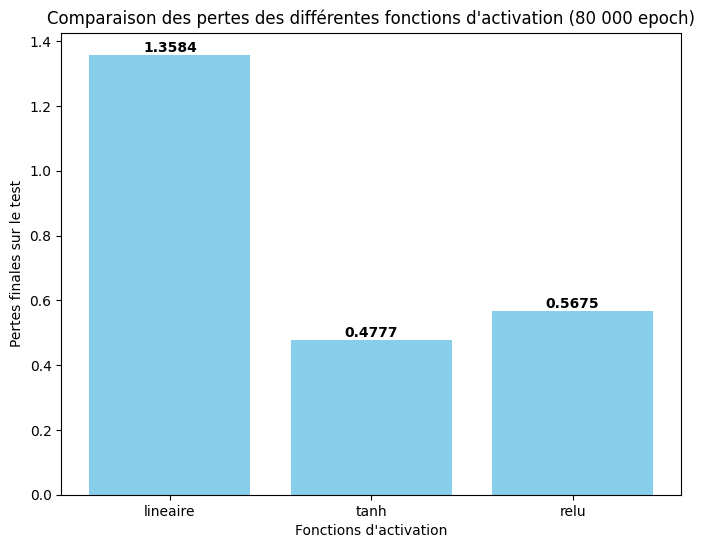

In [14]:
# Extraire les noms des activations et les pertes finales en convertissant en float
activation_names = [item[0] for item in cost_final]
loss_values = [float(item[1]) for item in cost_final]

# Créer l'histogramme
plt.figure(figsize=(8, 6))
plt.bar(activation_names, loss_values, color='skyblue')

# Ajouter les étiquettes et le titre
plt.xlabel('Fonctions d\'activation')
plt.ylabel('Pertes finales sur le test')
plt.title('Comparaison des pertes des différentes fonctions d\'activation (80 000 epoch)')

# Afficher les valeurs au-dessus des barres
for i, v in enumerate(loss_values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')

# Afficher le graphique
plt.show()